In [1]:
from pyrosm import OSM
import geopandas as gpd
import pandas as pd
import networkx as nx
import osmnx as ox
from shapely.geometry import Point, Polygon, MultiPoint
import folium
import matplotlib.pyplot as plt
import alphashape
import contextily 
from descartes import PolygonPatch


<Axes: >

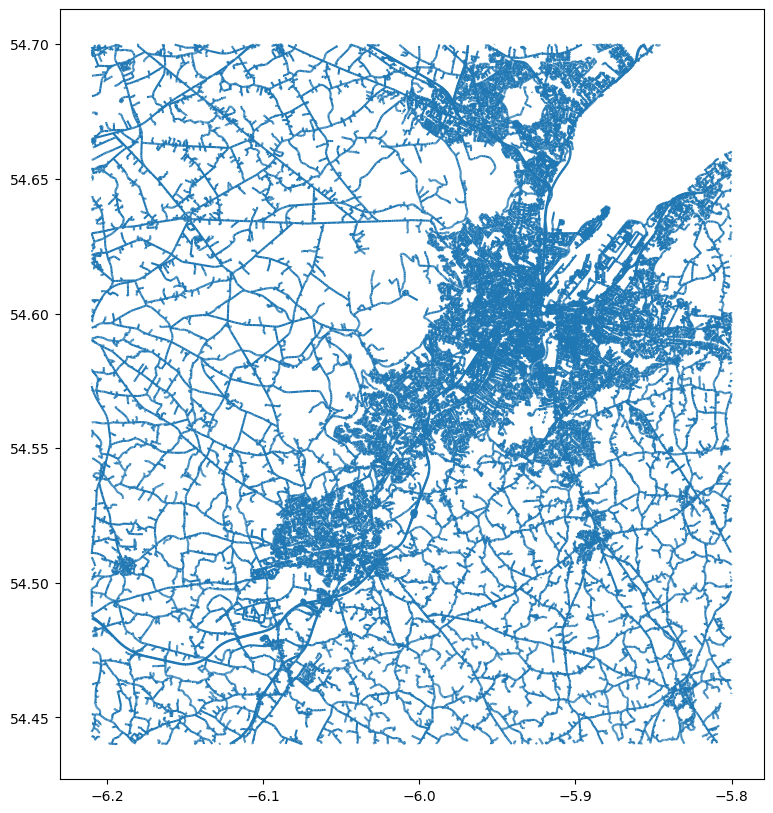

In [2]:
# assign file path to osm pbf file.
base_road_path = 'C:/Users/hular/projects/ClosestDestination/testEnvironment/Data/belfast.osm.pbf'

osm = OSM(base_road_path)

#load road network from graph
G_network = osm.get_network(network_type = 'driving', nodes = True)

# #Convert to ga graph (this will create if not a pyrosm source)
# if not isinstance(G, nx.Graph):
#     G = nx.from_pandas_edgelist(G, source='u', target='v', edge_attr=True)

nodes, edges = osm.get_network(network_type='driving', nodes=True)

#generate graph of network
G = osm.to_graph(nodes, edges, graph_type='networkx')

edges.plot(figsize=(10,10))

In [3]:
#load in the data which service areas will be analysed.
#sticking it in a try loop forces it to work.
service_locations_csv = pd.read_csv('C:/Users/hular/projects/ClosestDestination/testEnvironment/Data/libraries_belfast_2024.csv')

def csv_to_gdf(csv = service_locations_csv, x = 'X COORDINATE', y = 'Y COORDINATE', input_crs = 29902, crs_conversion = None):
    """ function to convert csv to a gdf based off X, Y coordinates and input CRS. Optional CRS conversion.
    
        Parameters:
    - csv: DataFrame, source data.
    - x: str, column name for the x coordinate.
    - y: str, column name for the y coordinate.
    - input_crs: int, EPSG code for input coordinate reference system.
    - crs_conversion: int, optional EPSG code for converting CRS."""
    #create a list for each row of geom by zipping and turn into a point tuple
    try:
        csv['geometry'] = list(zip(csv[x], csv[y]))
        csv['geometry'] = csv['geometry'].apply(Point)
        # Convert to GeoDataFrame
        gdf = gpd.GeoDataFrame(csv, geometry='geometry', crs=f'EPSG:{input_crs}')
        #Only converts if specified
        if crs_conversion:
            gdf = gdf.to_crs(epsg=crs_conversion)
        return gdf
    except Exception:
        print(f'Exception error: {Exception}')
        
        # Return the GeoDataFrame

service_locations = csv_to_gdf(csv=service_locations_csv, crs_conversion=4326)
service_locations.head(25)

,Static Library Name,Number,Street,Town,Postcode,Tel No,X COORDINATE,Y COORDINATE,geometry
0,Ardoyne Library,446-450,Crumlin Road,Belfast,BT14 7GH,028 9050 9202,331131,376131,POINT (-5.97089 54.61635)
1,Ballyhackamore Library,001-003,Eastleigh Drive,Belfast,BT4 3DX,028 9050 9204,337952,373959,POINT (-5.86641 54.59504)
2,Belfast Central Library,124,Royal Avenue,Belfast,BT1 1EA,028 9050 9150,333722,374686,POINT (-5.93147 54.60270)
3,Chichester Library,109,Salisbury Avenue,Belfast,BT15 5EB,028 9050 9210,332965,377688,POINT (-5.94182 54.62985)
4,Colin Glen Library,Unit 17,"The Dairy Farm Centre, Stewartstown Road",Belfast,BT17 0AW,028 9043 1266,328119,369828,POINT (-6.02023 54.56054)
5,Cregagh Library,409-413,Cregagh Road,Belfast,BT6 0LF,028 9040 1365,336143,371283,POINT (-5.89561 54.57151)
6,Falls Road Library,49,Falls Road,Belfast,BT12 4PD,028 9050 9212,332347,374131,POINT (-5.95298 54.59808)
7,Finaghy Library,38B,Finaghy Road South,Belfast,BT10 0DR,028 9050 9214,330520,369835,POINT (-5.98314 54.55999)
8,Grove Library,120,York Road,Belfast,BT15 3HF,028 9050 9244,334106,376724,POINT (-5.92460 54.62089)
9,Holywood Arches Library,004-012,Holywood Road,Belfast,BT4 1NT,028 9050 9216,336488,374235,POINT (-5.88891 54.59791)


In [4]:
from pyproj import Proj, transform

# Define the projection from Irish Grid (EPSG:29902) to WGS 84 (EPSG:4326)
proj_ireland = Proj(init='epsg:29902')
proj_wgs84 = Proj(init='epsg:4326')

# Example coordinates from your data (e.g., Ballyclare Library)
x, y = 284431, 432491

# Convert from Irish Grid to WGS 84
lon, lat = transform(proj_ireland, proj_wgs84, x, y)
print(f"Converted Longitude: {lon}, Latitude: {lat}")

Converted Longitude: -6.677040358568422, Latitude: 55.1324399219597


c:\Users\hular\anaconda3\envs\netgeo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
c:\Users\hular\anaconda3\envs\netgeo_env\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)
C:\Users\hular\AppData\Local\Temp\ipykernel_19324\2851995413.py:11: FutureWarning: This function is deprecated. See: https://pyproj4.github.io/pyproj/stable/gotchas.html#upgrading-to-pypro

In [5]:

#Function to create a dict of names and nearest names to be called in a loop creating the subgraphs for each location.
def nearest_node_and_name(Network_graph, locations, name):
    """ Create a dictionary of location names and nearest node on Graph  """   
    service_xy = {}
    
    for index, row in locations.iterrows():
        #extract x and y for each library
        location_x = row['geometry'].x
        location_y = row['geometry'].y
        #calculate the nearest node on the Graph
        nearest_node = ox.distance.nearest_nodes(Network_graph, location_x, location_y)
        # extract the library name
        name = row['Static Library Name']
        #Combine the name and nearest name. 
        service_xy[name] = {'nearest_node': nearest_node}
    return service_xy

service_locations_nearest_node = nearest_node_and_name(G, service_locations, 'Static Library Name')


In [6]:

def single_source_polygon(nearest_node_dict, graph = G, alpha_value = 500):
    service_areas_dict = {}
    geom_for_gdf = []
    #For each start location [name], 
    for name in nearest_node_dict:     
        #Extract nearest node to the name (start location)
        nearest_node = nearest_node_dict[name]['nearest_node']
        subgraph = nx.single_source_dijkstra_path_length(graph, nearest_node, cutoff=1000, weight = 'length')
        
        #Creates a list of all nodes which are reachable within the cutoff.
        reachable_nodes = list(subgraph.keys())
        node_points_list = []
        for node in reachable_nodes:
            x = graph.nodes[node]['x']
            y = graph.nodes[node]['y']
            node_points_list.append(Point(x, y))
        
        # Makes the x,y values into just a list of tuples to be used with alpha shape
        node_points_series = pd.Series(node_points_list)
        node_point_series_tuples_list = node_points_series.apply(lambda point: (point.x, point.y))
        correct_points_list = node_point_series_tuples_list.tolist()
        
        #Create an alpha shape for each polygon.
        alpha_shape = alphashape.alphashape(correct_points_list, alpha_value)
        geom_for_gdf.append({'name': name, 'geometry': alpha_shape})
        service_areas_dict[name] = alpha_shape

    gdf_alpha = gpd.GeoDataFrame(geom_for_gdf, crs= 4326)    
    #return dict for printing
    return gdf_alpha

    


test = single_source_polygon(nearest_node_dict= service_locations_nearest_node, graph = G, alpha_value=500)    
import pprint
pprint.pprint(test) 

                       name                                           geometry
0           Ardoyne Library  POLYGON ((-5.96428 54.61086, -5.96542 54.61113...
1    Ballyhackamore Library  POLYGON ((-5.87514 54.59279, -5.87679 54.59275...
2   Belfast Central Library  POLYGON ((-5.94341 54.60205, -5.94431 54.60258...
3        Chichester Library  POLYGON ((-5.94494 54.62531, -5.94641 54.62516...
4        Colin Glen Library  POLYGON ((-6.02844 54.55534, -6.02965 54.55630...
5           Cregagh Library  POLYGON ((-5.89180 54.57839, -5.89143 54.57811...
6        Falls Road Library  POLYGON ((-5.95574 54.60124, -5.95481 54.60194...
7           Finaghy Library  POLYGON ((-5.99231 54.55959, -5.99277 54.56004...
8             Grove Library  POLYGON ((-5.92175 54.61751, -5.92179 54.61739...
9   Holywood Arches Library  POLYGON ((-5.87930 54.59268, -5.88124 54.59162...
10     Lisburn Road Library  POLYGON ((-5.95179 54.56613, -5.95195 54.56615...
11     Newtownbreda Library  POLYGON ((-5.90798 54.5

C:\Users\hular\AppData\Local\Temp\ipykernel_19324\2561479273.py:10: UserWarning: Legend does not support handles for PatchCollection instances.
See: https://matplotlib.org/stable/tutorials/intermediate/legend_guide.html#implementing-a-custom-legend-handler
  plt.legend(loc='upper right', fontsize = 'small', title='Legend', fancybox = True, shadow = True, framealpha=0.9)


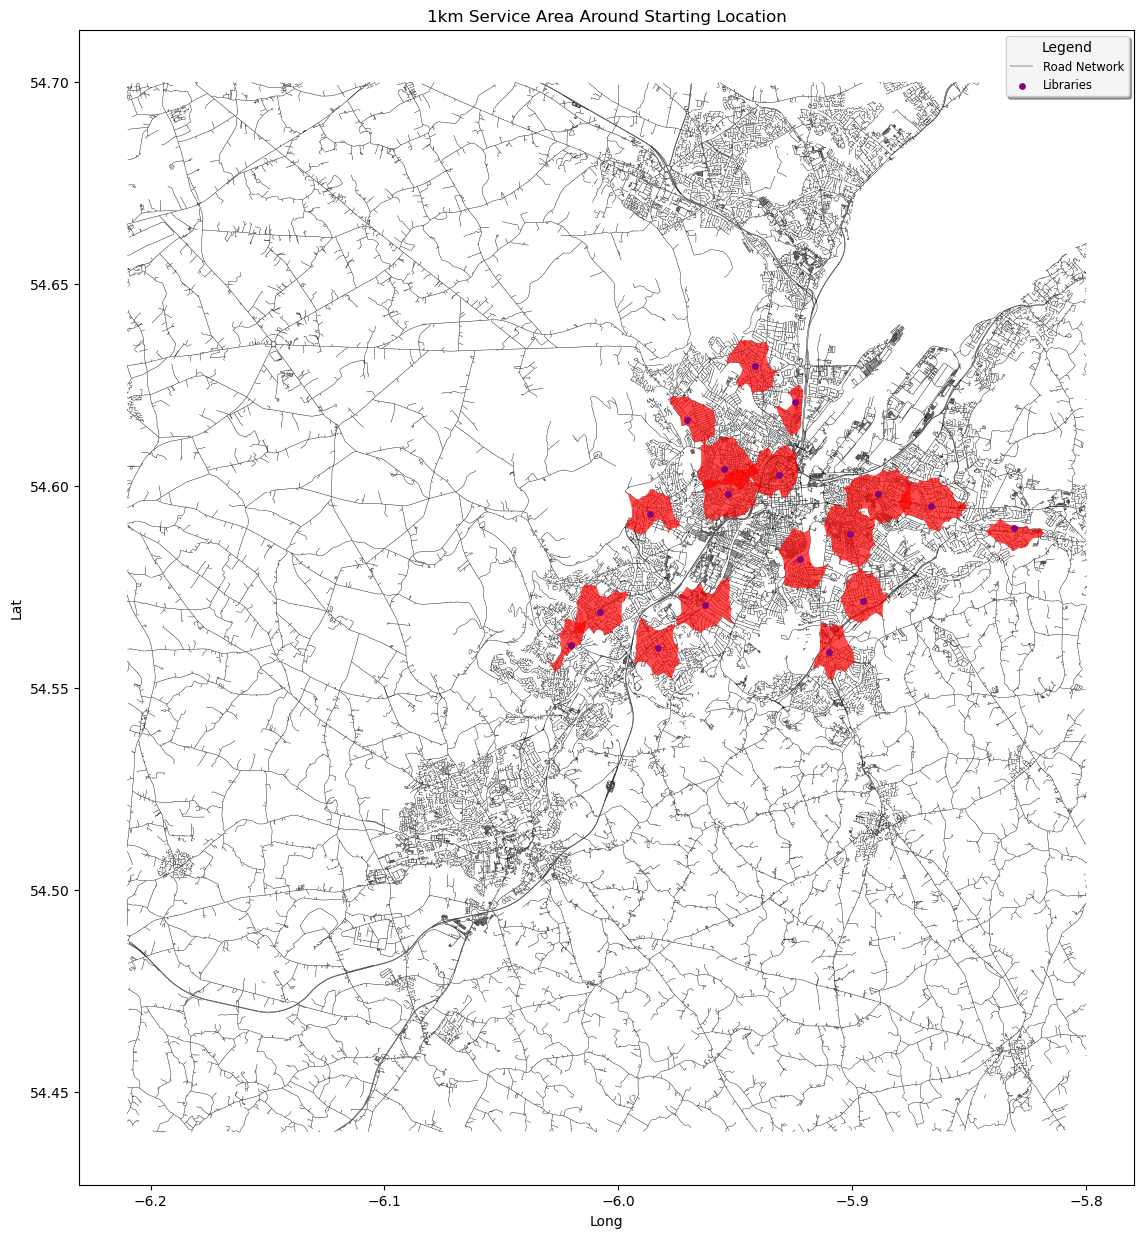

In [35]:
#create geodataframes alpha hull and points
fig, ax = plt.subplots(figsize=(15,15))

# Plot the alpha shape and nodes on same axes

test.plot(ax=ax, color='red', alpha=0.7, linewidth=0.1, label='1km Service Area', zorder=2)  
edges.plot(ax=ax, color='black', linewidth=0.3, label='Road Network', zorder=1)
service_locations.plot(ax=ax, color='purple', markersize=15, label='Libraries', zorder=3)

plt.legend(loc='upper right', fontsize = 'small', title='Legend', fancybox = True, shadow = True, framealpha=0.9)

ax.set_title(f'1km Service Area Around Starting Location')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')

plt.show()

In [8]:
#Example single not looped yet.
#loop over library nearest node dict with single_source_path_length, 
# create a new dict with name and polygons created from the reachable nodes and retain the travel distance.
#Create closest node for example. Loop this later.
single_location = service_locations.iloc[1]
x,y =(single_location['geometry'].x, single_location['geometry'].y)

nearest_node = ox.nearest_nodes(G, X=x, Y=y )

# distance in metres, time = seconds. For creation of subgraph
max_travel_distance = 1000

# Create a sub-graph and a list of nodes within the specified distance.
#subgraph = subsection of the main Graph based on cutoff
subgraph = nx.single_source_dijkstra_path_length(G, nearest_node, cutoff=max_travel_distance, weight='length')
reachable_nodes = list(subgraph.keys())

node_points = [Point(G.nodes[node]['x'], G.nodes[node]['y']) for node in reachable_nodes]
polygon = Polygon([[point.x, point.y] for point in node_points])
print(polygon)


POLYGON ((-5.866240501403809 54.59507369995117, -5.866238117218018 54.595123291015625, -5.866236209869385 54.59514617919922, -5.86622953414917 54.595184326171875, -5.866008281707764 54.59506607055664, -5.865941524505615 54.595062255859375, -5.866362571716309 54.59518814086914, -5.8663787841796875 54.595191955566406, -5.865889072418213 54.595062255859375, -5.866274356842041 54.59537887573242, -5.865689277648926 54.59505081176758, -5.866847038269043 54.595096588134766, -5.8658647537231445 54.595428466796875, -5.8658246994018555 54.595428466796875, -5.867319583892822 54.595123291015625, -5.865696907043457 54.59469985961914, -5.867316246032715 54.59516906738281, -5.867316722869873 54.59518051147461, -5.867317199707031 54.595218658447266, -5.865556716918945 54.59543228149414, -5.8655314445495605 54.595436096191406, -5.8655104637146 54.59543991088867, -5.866442680358887 54.5958251953125, -5.865488529205322 54.59545135498047, -5.865692615509033 54.594581604003906, -5.865474224090576 54.595466

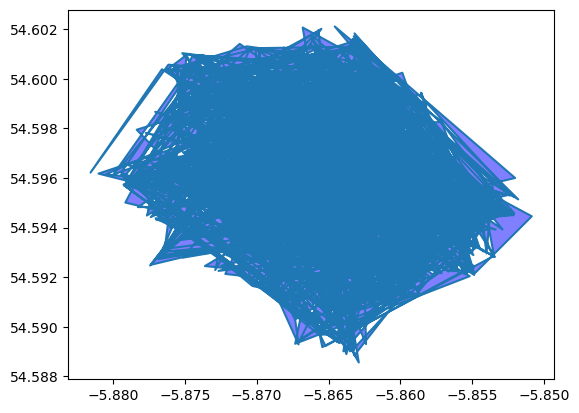

In [9]:
# Create a gdf for the polygon.
import geopandas as gpd
gdf = gpd.GeoDataFrame([polygon], columns=['geometry'], crs='EPSG:4326')

fig, ax = plt.subplots()
gdf.boundary.plot(ax=ax)
gdf.plot(ax=ax, color='blue', alpha=0.5)
plt.show()



service_point = (54.55998716608919, -5.983139503268679)  # Latitude, Longitude

m = folium.Map(location=[service_point[0], service_point[1]], zoom_start=14)

folium.GeoJson(gdf).add_to(m)

m.save(r"C:\Users\hular\projects\ClosestDestination\testEnvironment\service_area_map.html")

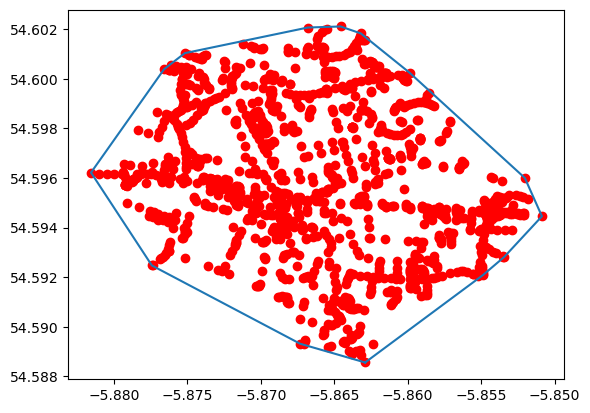

In [10]:
#convex hull creation. Very ugly. Kind of pointless.
points = MultiPoint(node_points)
convex_hull_polygon = points.convex_hull

#plot convex hull
x,y = convex_hull_polygon.exterior.xy
x_coords = [point.x for point in node_points]
y_coords = [point.y for point in node_points]
plt.figure()
plt.plot(x, y)
plt.scatter(x_coords, y_coords, color='red') # Scatter plot of the original points
plt.show()

In [11]:
#Convert to pandas series then extract the x and y coords from the list of tuples and then reassign as a list, this removes the 'geometry'.
node_points_series = pd.Series(node_points)
node_point_series_tuples_list = node_points_series.apply(lambda point: (point.x, point.y))
correct_points_list = node_point_series_tuples_list.tolist()
correct_points_list

[(-5.866240501403809, 54.59507369995117),
 (-5.866238117218018, 54.595123291015625),
 (-5.866236209869385, 54.59514617919922),
 (-5.86622953414917, 54.595184326171875),
 (-5.866008281707764, 54.59506607055664),
 (-5.865941524505615, 54.595062255859375),
 (-5.866362571716309, 54.59518814086914),
 (-5.8663787841796875, 54.595191955566406),
 (-5.865889072418213, 54.595062255859375),
 (-5.866274356842041, 54.59537887573242),
 (-5.865689277648926, 54.59505081176758),
 (-5.866847038269043, 54.595096588134766),
 (-5.8658647537231445, 54.595428466796875),
 (-5.8658246994018555, 54.595428466796875),
 (-5.867319583892822, 54.595123291015625),
 (-5.865696907043457, 54.59469985961914),
 (-5.867316246032715, 54.59516906738281),
 (-5.867316722869873, 54.59518051147461),
 (-5.867317199707031, 54.595218658447266),
 (-5.865556716918945, 54.59543228149414),
 (-5.8655314445495605, 54.595436096191406),
 (-5.8655104637146, 54.59543991088867),
 (-5.866442680358887, 54.5958251953125),
 (-5.865488529205322, 5

In [12]:
#alpha param can be defined locally within a region of points. this changes density density off X coordinates density
#lambda ind, r: 500.0 + any(np.array(correct_points_list)[ind][:, 0] == 0.0) #from the docs
alpha_value = 1000

print(alpha_value)
alpha_shape = alphashape.alphashape(correct_points_list, 
                                    alpha_value)

1000


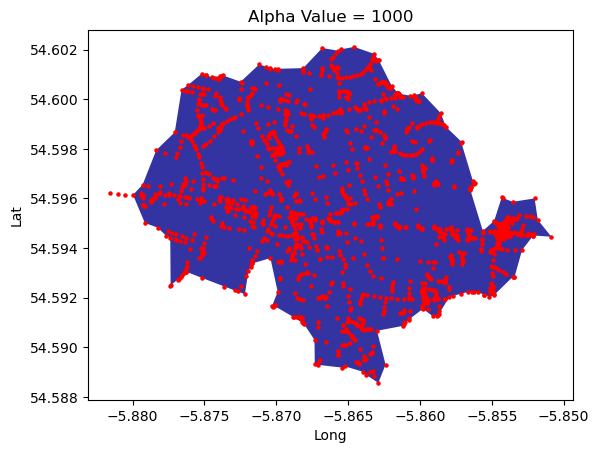

In [13]:
#create geodataframes alpha hull and points
gdf_alpha = gpd.GeoDataFrame(geometry=[alpha_shape], crs=4326)
points = [Point(xy) for xy in correct_points_list]
gdf_nodes = gpd.GeoDataFrame( geometry= node_points, crs = 4326)

fig, ax = plt.subplots()

# Plot the alpha shape and nodes on same axes
gdf_alpha.plot(ax=ax, color='darkblue', alpha=0.8)  
gdf_nodes.plot(ax=ax, color='red', markersize=5)

ax.set_title(f'Alpha Value = {alpha_value}')
ax.set_xlabel('Long')
ax.set_ylabel('Lat')

plt.show()
